If you are unfamiliar with scipy's ordinary differential equations, this is a great start.

https://ipython-books.github.io/123-simulating-an-ordinary-differential-equation-with-scipy/

If you need some rewind from dynamic system, Brigham Young University provides excellent and free materials.

The demonstration of HIV infection is a great example of ordinary differential equations.

https://apmonitor.com/pdc/index.php/Main/SimulateHIV

The demonstration of dual heater first ordered physics model is a great example of the non-linear least square estimation on dynamic system.

https://apmonitor.com/pdc/index.php/Main/ArduinoEstimation2

In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import datetime as dt
import os
import random as rd
import re
import pandas as pd
os.chdir('K:/a')

In [2]:
#get demographic data
def get_demographic(un_total,un_birth,un_death,country,year):
    
    #the unit is in '000
    population=un_total['Value'][un_total['Country or Area']==country][un_total['Year(s)']==(year+1)][un_total['Variant']=='Medium'].item()*1000
    population0=un_total['Value'][un_total['Country or Area']==country][un_total['Year(s)']==(year)][un_total['Variant']=='Medium'].item()*1000
    
    #for some reason, un doesnt provide crude rate per year, only annual rate per 5 year
    yearrange='%s-%s'%(2000+(year-2000)//5*5,2005+(year-2000)//5*5)
    
    #crude birth and death rate per 1000 people
    birth=un_birth['Value'][un_birth['Country or Area']==country][un_birth['Year(s)']==yearrange][un_birth['Variant']=='Medium'].item()/1000
    death=un_death['Value'][un_death['Country or Area']==country][un_death['Year(s)']==yearrange][un_death['Variant']=='Medium'].item()/1000
    
    #avoid python float error
    birth=round(birth,6)
    death=round(death,6)
    population=round(population,0)
    population0=round(population0,0)
    
    return (birth,death,population,population0)

In [3]:
#cleansing data
def prepare_data(df,demographic,country):
    
    birth,death,population,population0=demographic
    
    data=df[df['Country/Territory/Area']==country]
    data.set_index('report date',inplace=True)
    data.index=pd.to_datetime(data.index)

    #Total deaths denotes D in the dynamic system
    data=data[['Total deaths','Confirmed cases']].copy(deep=True)

    #currently infected denotes I in the dynamic system
    data['currently infected']=(data['Confirmed cases']-data['Total deaths'])

    #time denotes t in the dynamic system
    dif=pd.Series(data.index).diff()
    data['time']=dif.fillna('0').apply(lambda x: re.findall('\d+',str(x))[0]).astype(int).cumsum().tolist()

    #the tricky part is the susceptible
    #it is the total population minus confirmed cases
    #and the total population should also include natural birth and death

    #first we need to convert annual rate to daily rate as we got daily data
    birthdaily=(birth+1)**(1/365)-1
    deathdaily=(death+1)**(1/365)-1

    #the daily population projection excludes immigration and emigration
    #first, its challenging to find daily immigration and emigration data
    #i am pretty sure the government has it but i cannot find it for free
    #second, when the quarantines kicked in, no flights were allowed
    #many places in asia became a closed system
    ppl=pd.DataFrame()
    ppl['population']=[round(population0*((1+birthdaily-deathdaily)**i),0) for i in range(365)]
    ppl['report date']=[pd.to_datetime('2020-01-01')+dt.timedelta(days=i) for i in range(365)]
    ppl.set_index('report date',inplace=True)
    
    #merge
    data=data.merge(ppl,left_index=True,right_index=True)

    #susceptible denotes S in the dynamic system
    data['susceptible']=data['population']-data['Confirmed cases']
    
    data['alpha']=birthdaily
    data['gamma']=deathdaily
    data['country']=country
    
    return data

In [4]:
#modified version of si model with vital dynamic
#include natural birth, natural death and virus death
def SImodel(z,t,known,unknown):
    
    alpha,gamma=known
    beta,delta=unknown
    
    S=z[0]
    I=z[1]
    
    #we dont include virus caused death in the equations
    #becuz it is not used in any equation
    #its better to have a matrix with full rank
    dSdt=alpha*(S+I)-gamma*S-beta*S*I
    dIdt=beta*S*I-(gamma+delta)*I
    
    dzdt=[dSdt,dIdt]
    
    return dzdt

In [5]:
#put all differential equations together
def dynamicsystem(unknown):
    
    t=data['time'].tolist()
    
    alpha=data['alpha'].iloc[0]
    gamma=data['gamma'].iloc[0]
    
    #create a list to store fitted values
    fitted=np.zeros((len(t),2))
    
    #initial value
    fitted[0,0]=data['susceptible'].iloc[0]
    fitted[0,1]=data['currently infected'].iloc[0]
    
    z0=fitted[0]
    
    #we compute the fitted value via iterations
    #becuz this way is compatible with non-linear least square
    for i in range(1,len(t)):
        
        #unlike sars
        #corona report updates everyday
        #but we just keep this in case of any future change
        interval=[t[i-1],t[i]]
        
        z=odeint(SImodel,z0,interval,args=((alpha,gamma),unknown))
        
        #each iteration, the last fitted value becomes the initial value
        z0=z[-1]
        
        #we update fitted via each iteration
        fitted[i]=z[-1]
                
    return fitted

In [6]:
#the cost of least square is the sum of squared error
def costfunction(unknown):
    
    fitted=dynamicsystem(unknown)
    
    cost=0.0
    
    #S,I
    actual=['susceptible','currently infected']
    
    #we have 2 ordinary differential equations
    #so we include 2 errors in each round
    #and we standardize the errors by the actual values
    for i in range(len(data)):
        for j in range(len(actual)):
            
            #sometimes the actual data may be zero
            #we cannot standardize the error by division
            if data[actual[j]].iloc[i]==0:
                if round(fitted[i,j],0)>1:
                    cost+=1
                else:
                    cost+=0
            else:
                cost+=((fitted[i,j]-data[actual[j]].iloc[i])/data[actual[j]].iloc[i])**2 
    
    return cost

In [7]:
#using non linear least square to estimate the parameters of dynamic system
#as we can only find the local minimum
#the initial value is crucial to the result
def estimate(beta_guess=0.001,delta_guess=0.01,diagnosis=False,**kwargs):
       
    #sum of squared error from initial guess
    sse=costfunction((beta_guess,delta_guess))
    
    if diagnosis:
        print(f'Initial SSE: {round(sse,2)}')
    
    #according to rule of thumb, we use nelder-mead
    #actually i exhausted all possibilities
    #this one was the best empirical result
    #the shortcoming is nelder-mead doesnt take constraints
    #all rates should be bounded by 0 and 1
    lse=minimize(costfunction,x0=(beta_guess,delta_guess),
                 method='Nelder-Mead')
        
    if lse.success:   
        
        #sum of squared error from successful result
        beta,delta=lse.x
        sse=costfunction((beta,delta))
        
        if diagnosis:
            print(f'Result SSE: {round(sse,2)}')
        
        return beta,delta
        
    else:
        #if it doesnt converge to local minimum
        #we print the result and find out why
        if diagnosis:
            print(lse)
        return 0,0

In [8]:
#generate final outcome for in sample data
def create_in_sample_output(diagnosis=False,**kwargs):
    
    #estimate parameters
    beta,delta=estimate(**kwargs)
    
    if beta<=0 or delta<=0 or beta>1 or delta>1:
        if diagnosis:
            print('\nFailed\n')
        return None
    
    if diagnosis:
        print(f'\nInfection Rate: {round(beta,10)}')
        print(f'Fatality Rate: {round(delta,5)}')
    
    #show reproductive ratio
    R0=round(beta*data['susceptible'].iloc[0]/(data['gamma'].iloc[0]+delta),5)
    data['R0']=R0
    
    if diagnosis:
        print(f'\nBasic Reproductive Ratio: {R0}\n')

    #get model predictions
    fitted=dynamicsystem((beta,delta))

    data['susceptible fitted']=fitted[:,0]
    data['infected fitted']=fitted[:,1]

    #as death is not in differential equations
    #we need to compute it separately
    D=[data['Total deaths'].iloc[0]]

    for i in range(1,len(data)):
        D.append(round(D[-1]+delta*data['infected fitted'].iloc[i],0))

    data['death fitted']=D

    #convert float to int
    for i in data.columns:
        if 'fitted' in i:
            data[i]=data[i].apply(lambda x: round(x,0)).astype(int)
    
    #sum of squared error of death
    sse_d=sum((data['susceptible']-data['susceptible fitted']).apply(lambda x:x**2))
            
    return sse_d

In [9]:
#using random initial value to find the best starting point
#the best start point is defined by the minimum SSE of D
#even D is not in our differential equations
#we believe the global minimum should successfully capture D as well
#in reality, its not a good idea to run 10k times
#it took the whole night to get a result
#luckily i chose to sleep it off
def find_init(num=10000):
    D={}

    for _ in range(num):

        beta_random=rd.randint(1,1e+10)/10**(rd.randint(11,21))
        delta_random=rd.randint(1,1e+10)/10**(rd.randint(11,21))

        try:
            temp=create_in_sample_output(beta_guess=beta_random, delta_guess=delta_random)
            if temp:
                D[(beta_random,delta_random)]=temp
        except:
            pass
        
    return dict(sorted(D.items(),key=lambda x:x[1]))

In [10]:
#the best initial guess should suffice to 3 criteria
#smallest death sse,smallest overall sse including death and smallest r0
#and the default weight is slightly leaned towards death sse
def find_best_init(D,weight=[0.4,0.3]):
    
    global data

    D2={}
    D3={}

    databackup=data.copy(deep=True)
    
    #calculate the overall sum of squared error for each initial guess
    #this sum of squared error includes death as well
    for i in D:
        data=databackup.copy(deep=True)
        beta_guess,delta_guess=i
        if create_in_sample_output(beta_guess=beta_guess, delta_guess=delta_guess):
            sse=[((data['death fitted']-data['Total deaths'])/data['Total deaths'])**2,
            ((data['currently infected']-data['infected fitted'])/data['currently infected'])**2,
            ((data['susceptible']-data['susceptible fitted'])/data['susceptible'])**2]

            totalsse=sum([sum(i) for i in sse])

            D2[(beta_guess,delta_guess)]=totalsse
            D3[(beta_guess,delta_guess)]=data['R0'].iloc[0].item()

    D2=dict(sorted(D2.items(),key=lambda x:x[1]))
    D3=dict(sorted(D3.items(),key=lambda x:x[1]))
    
    #the best initial guess should balance the overall sse, R0 and death sse
    D4={}

    for i in D2:
        ind1=list(D.keys()).index(i)
        ind2=list(D2.keys()).index(i)        
        ind3=list(D3.keys()).index(i)

        D4[i]=ind1*weight[0]+ind2*weight[1]+ind3*(1-sum(weight))

    D4=dict(sorted(D4.items(),key=lambda x:x[1]))
    
    return D4

In [11]:
#generate final outcome for in sample data
def create_forecast(diagnosis=False,length=365,**kwargs):
    
    global data
            
    #estimate parameters
    beta,delta=estimate(**kwargs)
    
    if beta<=0 or delta<=0 or beta>1 or delta>1:
        if diagnosis:
            print('\nFailed\n')
        return False
    
    if diagnosis:
        print(f'\nInfection Rate: {round(beta,10)}')
        print(f'Fatality Rate: {round(delta,5)}')
    
    #show reproductive ratio
    R0=round(beta*data['susceptible'].iloc[0]/(data['gamma'].iloc[0]+delta),5)
    data['R0']=R0
    
    if diagnosis:
        print(f'\nBasic Reproductive Ratio: {R0}\n')
    
    #expand the time horizon of data
    start=data.index[-1]
    forecast=pd.DataFrame(index=[start+dt.timedelta(days=i) for i in range(1,length)],
                         columns=data.columns)
    data=data.append(forecast)
    dif=pd.Series(data.index).diff()
    data['time']=dif.fillna('0').apply(lambda x: re.findall('\d+',str(x))[0]).astype(int).cumsum().tolist()


    #get model predictions
    fitted=dynamicsystem((beta,delta))

    data['susceptible fitted']=fitted[:,0]
    data['infected fitted']=fitted[:,1]

    #as death is not in differential equations
    #we need to compute it separately
    D=[data['Total deaths'].iloc[0]]

    for i in range(1,len(data)):
        D.append(round(D[-1]+delta*data['infected fitted'].iloc[i],0))

    data['death fitted']=D

    #convert float to int
    for i in data.columns:
        if 'fitted' in i:
            data[i]=data[i].apply(lambda x: round(x,0)).astype(int)
            
    
    return True

In [12]:
#single plot for in sample data
def plot(actualcol,fittedcol,title,fig,order,color1,color2):    
    
    ax=fig.add_subplot(order)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.title(data['country'].iloc[0]+'\n'+title)
    plt.ylabel('number')
    plt.xlabel('date')
    
    data[actualcol].loc[data.dropna().index].plot(label='Actual',alpha=0.9,c=color1)
    data[fittedcol].loc[data.dropna().index].plot(label='Fitted',alpha=0.9,c=color2)
    
    plt.legend(loc=0)

In [13]:
#plot S,I,D in a 2 by 2 figure for in sample data
def plot_all(savefig=False):
    
    #plot actual versus fitted
    iteration=[('susceptible','susceptible fitted','Susceptible Population',221,'#1f6521','#d6ce15'),
    ('currently infected','infected fitted','Currently Infected',222,'#f13c20','#f79e02'),
    ('Total deaths','death fitted','Virus-caused Death',223,'#4d6d9a','#99ced3')]

    fig=plt.figure(figsize=(12,8))

    for i in iteration:

        actualcol,fittedcol,title,order,color1,color2=i
        plot(actualcol,fittedcol,title,fig,order,color1,color2)
        
    #plot the forecast of S,I,D
    ax=fig.add_subplot(224)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.title(data['country'].iloc[0]+'\n'+'Forecast')
    plt.ylabel('number')
    plt.xlabel('date')
    
    
    for col,color in zip([i for i in data.columns if 'fitted' in i],['#1f6521','#f13c20','#4d6d9a']):
        data[col].plot(label=col.replace(' fitted',''),alpha=0.7,c=color)
    
    plt.legend(loc=0)    
    
    #avoid messed up title and xlabel 
    plt.tight_layout(pad=1.5)
        
    if savefig:
        figname=f"differential-corona-{data['country'].iloc[0]}-in sample.png"
        plt.savefig(figname.lower())
    
    plt.show()

&nbsp;
### Pre-processing Data
&nbsp;

In [14]:
un_birth=pd.read_csv('birth.csv')
un_death=pd.read_csv('death.csv')
un_total=pd.read_csv('total.csv')
df=pd.read_csv('grand-corona.csv')

In [15]:
var=locals()

mapping={'World':'tt','China': 'cn',
         'China, Hong Kong SAR': 'hk',
         'Singapore': 'sg','Canada': 'ca',
         'United States of America':'us',
         'United Kingdom':'uk','Australia':'au',
         'France':'fr','Germany':'de','China, Macao SAR':'mc',
         'Philippines':'ph','Malaysia':'my',
         'Viet Nam': 'vn','Thailand': 'th',
         'Republic of Korea':'kr'}

for i in mapping:
    var[mapping[i]+'demographic']=get_demographic(un_total,un_birth,un_death,i,2019)
    
    #the irritating part where different country names are used
    #fucking politics
    if i=='China, Hong Kong SAR':
        country='Hong Kong'
    elif i=='China, Macao SAR':
        country='Macau'
    elif i=='World':
        country='Total'
    else:
        country=i
        
    var['data'+mapping[i]]=prepare_data(df,var[mapping[i]+'demographic'],country)

&nbsp;
### In-sample Data
&nbsp;

In [16]:
#using global variable is the worst idea
#but we need to call our dataframe inside the differential equations
#odeint prefers a clean dynamic system function with only numerical inputs
#therefore we have to define the dataframe as the global variable
global data

In [17]:
data=datacn.copy(deep=True)
D=find_init(num=50)
D4=find_best_init(D)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)



Infection Rate: 2e-10
Fatality Rate: 0.00349

Basic Reproductive Ratio: 63.30002



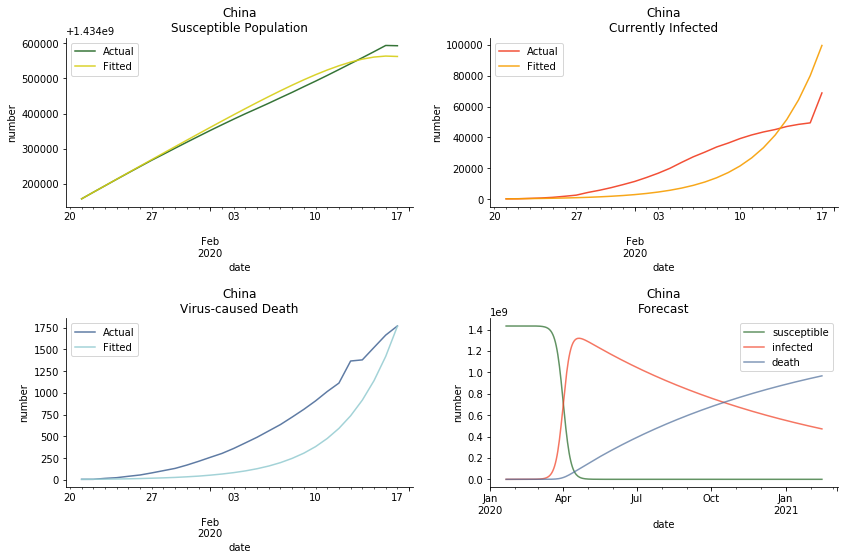

In [18]:
#after 10k iterations, this is the ideal initial guess
data=datacn.copy(deep=True)
beta_guess,delta_guess=9.8e-10, 0.002
if create_forecast(beta_guess=beta_guess, delta_guess=delta_guess,diagnosis=True):
    plot_all()

In [19]:
data=datahk.copy(deep=True)
D=find_init(num=50)

#since there is only one death
#we should focus on r0 and overall sse
D4=find_best_init(D,weight=[0,0.5])

C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)



Infection Rate: 2.49e-08
Fatality Rate: 0.00452

Basic Reproductive Ratio: 40.88525



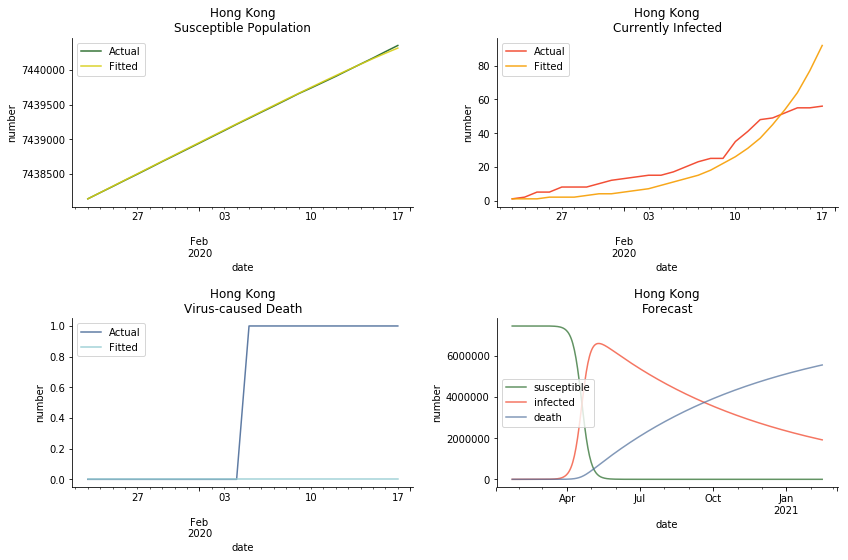

In [20]:
data=datahk.copy(deep=True)
beta_guess,delta_guess=5.6e-08, 0.003
if create_forecast(beta_guess=beta_guess, delta_guess=delta_guess,diagnosis=True):
    plot_all()

In [21]:
data=datasg.copy(deep=True)
D=find_init(num=50)
D4=find_best_init(D,weight=[0,0.5])

C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)



Infection Rate: 3.48e-08
Fatality Rate: 0.00356

Basic Reproductive Ratio: 56.62526



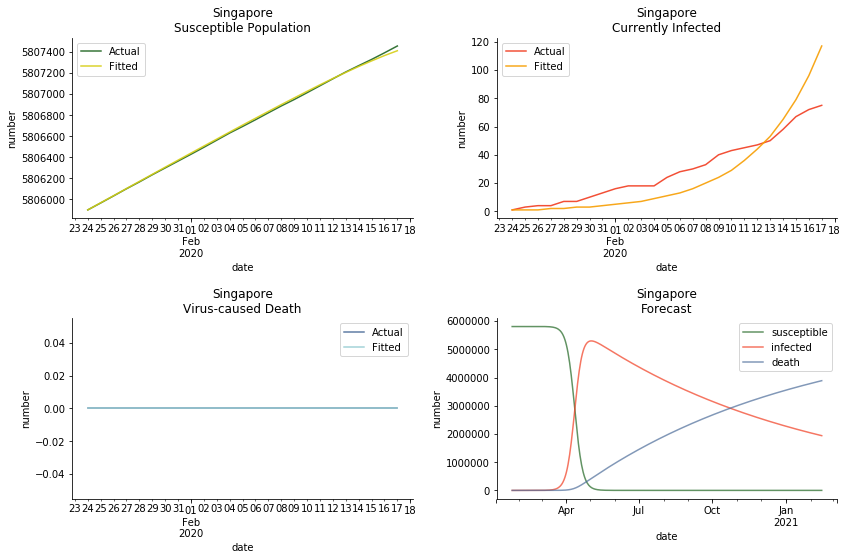

In [22]:
data=datasg.copy(deep=True)
beta_guess,delta_guess=1e-6, 0.002
if create_forecast(beta_guess=beta_guess, delta_guess=delta_guess,diagnosis=True):
    plot_all()

In [23]:
data=dataca.copy(deep=True)
D=find_init(num=50)
D4=find_best_init(D,weight=[0,0.5])

C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)



Infection Rate: 4e-09
Fatality Rate: 0.03647

Basic Reproductive Ratio: 4.06529



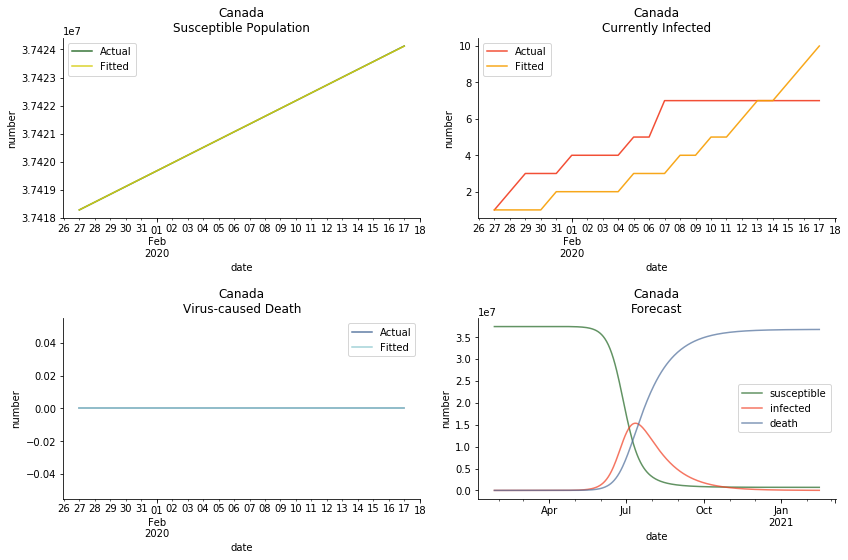

In [24]:
data=dataca.copy(deep=True)
beta_guess,delta_guess=5.6e-08, 0.02
if create_forecast(beta_guess=beta_guess, delta_guess=delta_guess,diagnosis=True):
    plot_all()

In [25]:
data=dataus.copy(deep=True)
D=find_init(num=50)
D4=find_best_init(D,weight=[0,0.5])

C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Repeated error test failures (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)



Infection Rate: 4e-10
Fatality Rate: 0.01846

Basic Reproductive Ratio: 7.82089



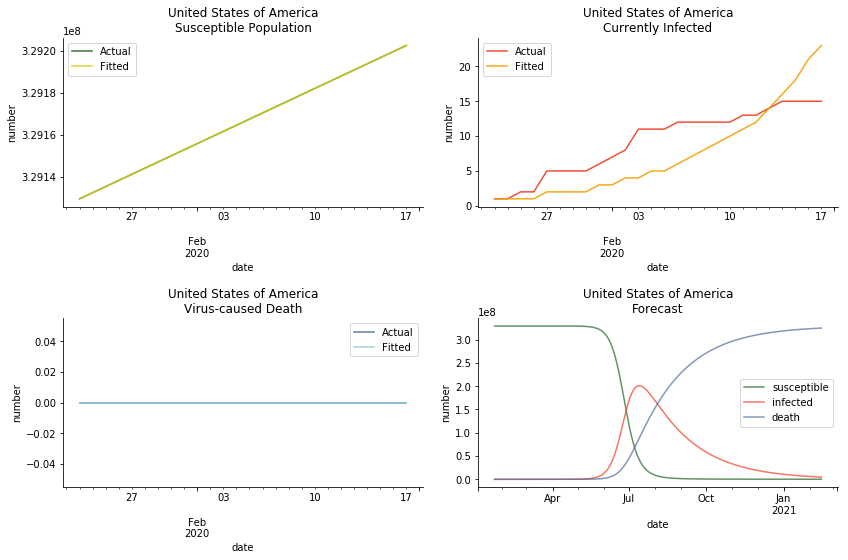

In [26]:
data=dataus.copy(deep=True)
beta_guess,delta_guess=1.6e-08, 0.01
if create_forecast(beta_guess=beta_guess, delta_guess=delta_guess,diagnosis=True):
    plot_all()

In [27]:
data=datavn.copy(deep=True)
D=find_init(num=50)
D4=find_best_init(D,weight=[0,0.5])

C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)



Infection Rate: 1.2e-09
Fatality Rate: 0.01798

Basic Reproductive Ratio: 6.43995



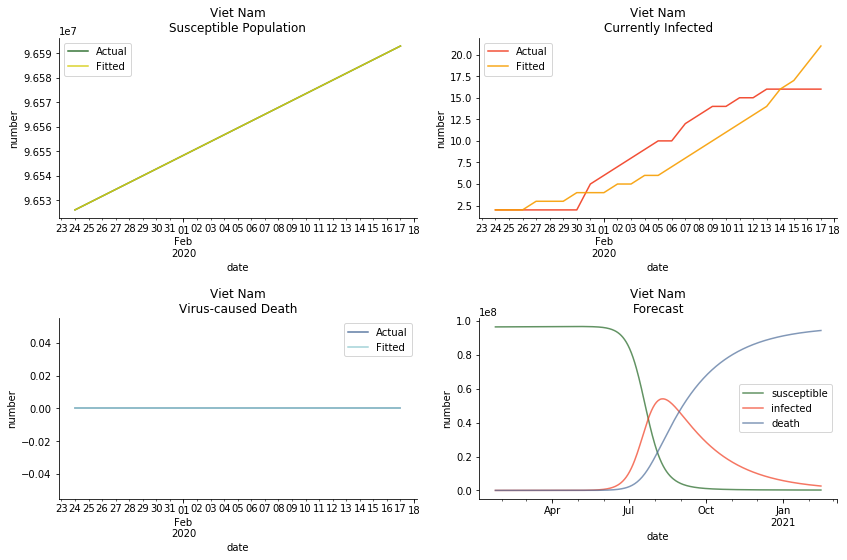

In [28]:
data=datavn.copy(deep=True)
beta_guess,delta_guess=2e-07, 0.01
if create_forecast(beta_guess=beta_guess, delta_guess=delta_guess,diagnosis=True):
    plot_all()

In [29]:
data=datamy.copy(deep=True)
D=find_init(num=50)
D4=find_best_init(D,weight=[0,0.5])

C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)



Infection Rate: 3.8e-09
Fatality Rate: 0.01652

Basic Reproductive Ratio: 7.27176



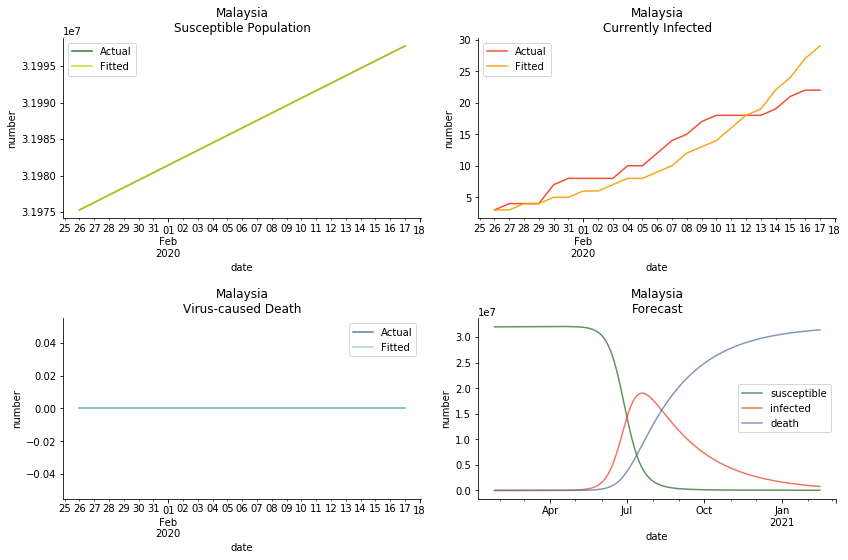

In [30]:
data=datamy.copy(deep=True)
beta_guess,delta_guess=3e-07, 0.009
if create_forecast(beta_guess=beta_guess, delta_guess=delta_guess,diagnosis=True):
    plot_all()

In [31]:
data=datath.copy(deep=True)
D=find_init(num=50)
D4=find_best_init(D,weight=[0,0.7])

C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)



Infection Rate: 1.9e-09
Fatality Rate: 0.00825

Basic Reproductive Ratio: 15.83738



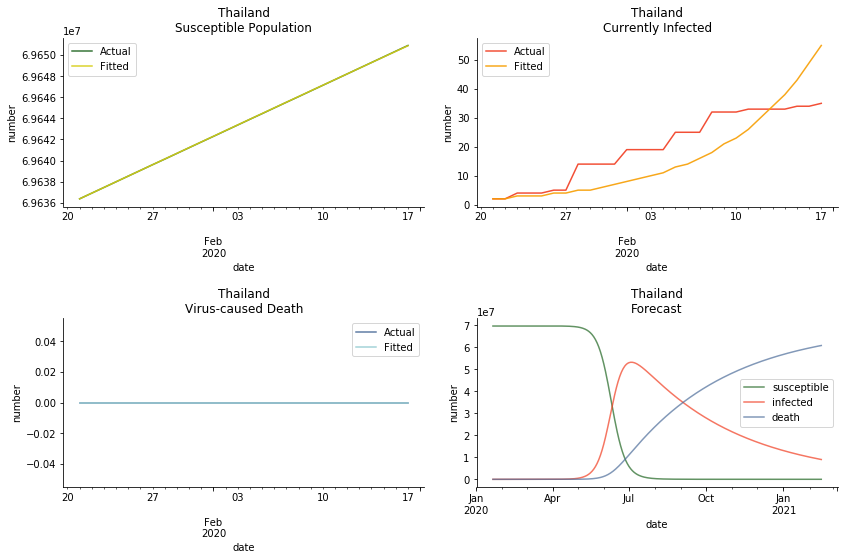

In [32]:
data=datath.copy(deep=True)
beta_guess,delta_guess=6.4e-09, 0.005
if create_forecast(beta_guess=beta_guess, delta_guess=delta_guess,diagnosis=True):
    plot_all()

In [33]:
data=datafr.copy(deep=True)
D=find_init(num=50)
D4=find_best_init(D,weight=[0,0.5])

C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)



Infection Rate: 1.3e-09
Fatality Rate: 0.01975

Basic Reproductive Ratio: 4.24613



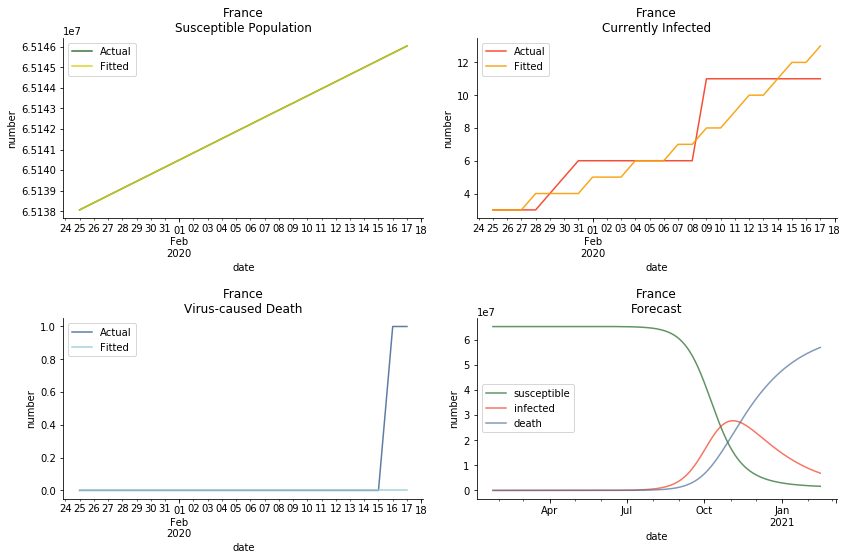

In [34]:
data=datafr.copy(deep=True)
beta_guess,delta_guess=8.09e-10, 0.065
if create_forecast(beta_guess=beta_guess, delta_guess=delta_guess,diagnosis=True):
    plot_all()

In [35]:
data=datade.copy(deep=True)
D=find_init(num=50)
D4=find_best_init(D,weight=[0,0.5])

C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)



Infection Rate: 2.1e-09
Fatality Rate: 0.01668

Basic Reproductive Ratio: 10.65088



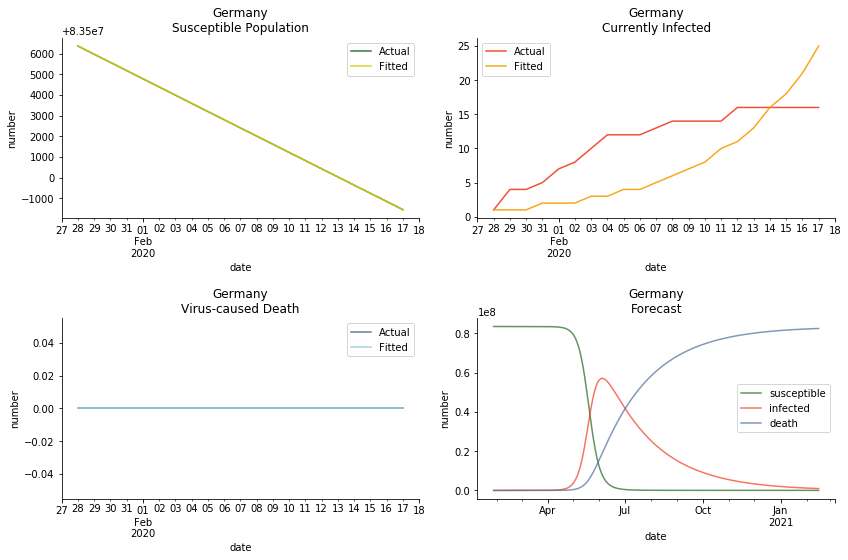

In [36]:
data=datade.copy(deep=True)
beta_guess,delta_guess=2.4e-09, 0.015
if create_forecast(beta_guess=beta_guess, delta_guess=delta_guess,diagnosis=True):
    plot_all()